# S2

**Which aspects (accuracy, cleanliness, check-in, or communication) show the greatest differences between the best- and worst-rated accommodations in the overall evaluation?**

In [896]:
# Import necessary libraries
import os
import warnings

# Data handling
import pandas as pd
import numpy as np

# Statistical analysis
from scipy import stats
from scipy.stats import (
    shapiro, ks_2samp, skew, kurtosis, 
    ttest_ind, mannwhitneyu
)
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings("ignore")

In [897]:
sns.set_theme(
    style="white",         # Clean background
    context="talk",        # Larger labels for presentations
    palette="seismic"      # High-contrast color palette
)

plt.rcParams.update({
    "axes.titlesize": 18,         # Title font size
    "axes.labelsize": 14,         # Axis label font size
    "xtick.labelsize": 12,        # X-axis tick label size
    "ytick.labelsize": 12,        # Y-axis tick label size
    "figure.figsize": (10, 6),    # Default figure size
    "figure.dpi": 100,            # Figure resolution
    "axes.grid": False,           # No grid lines for a cleaner look
    "axes.spines.top": False,     # Remove top border
    "axes.spines.right": False    # Remove right border
})


## Data Loading

In [899]:
PATH = 'Data'
SPRINT = 2
FILENAME = f'Tourist_Accommodation31032025.csv'

In [900]:
def read_file(filename):
    """
    Input: filename (string) - path to the .csv file.
    Function reads .csv data with specific date columns parsed.
    Output: DataFrame or error message.
    """
    try:
        # Reading the file and parsing dates
        df = pd.read_csv(os.path.join('..', PATH, filename), parse_dates=['insert_date', 'first_review_date', 'last_review_date'], dayfirst=True)
        display(df.head())        
        return df
    except Exception as error:
        print("An exception occurred:", error)
        return None

In [901]:
df = read_file(filename)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community,has_reviews
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2.00,1.00,...,100.00,0,75.00,spain,malaga,2018-07-31,Málaga,Centro,Andalucía,True
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.00,1.00,...,90.00,0,52.00,spain,madrid,2020-01-10,Madrid,Los Cármenes,Comunidad de Madrid,True
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.00,2.00,...,100.00,1,142.00,spain,sevilla,2019-07-29,Sevilla,San Vicente,Andalucía,True
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.00,1.00,...,90.00,1,306.00,spain,barcelona,2020-01-10,Barcelona,L'Antiga Esquerra de l'Eixample,Cataluña,True
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1.00,2.00,...,100.00,0,39.00,spain,girona,2019-02-19,Girona,Quart,Cataluña,True


In [902]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7643 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7652 non-null   float64       
 9   bedrooms                     7654 non-null   float64       
 10  beds                         7685 non-null   float64       
 11  amenities_list               7677 non-null 

## Clean data  

Preparación de datos  
**Filtramos solo alojamientos con reviews completas**

In [905]:
# Remove rows without reviews 
df_filtered=df[df['number_of_reviews'] != 0]

# Checking NaN values 
print(f"Missing values:\n{df_filtered[review_columns].isnull().sum()}")

Missing values:
review_scores_rating           83
review_scores_accuracy         92
review_scores_cleanliness      86
review_scores_checkin          97
review_scores_communication    88
review_scores_location         98
review_scores_value            98
dtype: int64


In [906]:
# Drop rows with NaN values in the selected review columns
df_filtered = df.dropna(subset=['review_scores_rating', 'review_scores_accuracy', 
                             'review_scores_cleanliness', 'review_scores_checkin',
                             'review_scores_communication', 'review_scores_location',
                             'review_scores_value'])

# Checking NaN values 
print(f"Missing values:\n{df_filtered[review_columns].isnull().sum()}")

Missing values:
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64


In [907]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6039 entries, 0 to 7692
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6039 non-null   int64         
 1   name                         6039 non-null   object        
 2   description                  6015 non-null   object        
 3   host_id                      6039 non-null   int64         
 4   neighbourhood_name           6039 non-null   object        
 5   neighbourhood_district       3901 non-null   object        
 6   room_type                    6039 non-null   object        
 7   accommodates                 6039 non-null   int64         
 8   bathrooms                    6008 non-null   float64       
 9   bedrooms                     6007 non-null   float64       
 10  beds                         6039 non-null   float64       
 11  amenities_list               6031 non-null   obj

In [908]:
print(df_filtered.columns)

Index(['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name',
       'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'is_instant_bookable', 'reviews_per_month',
       'country', 'city', 'insert_date', 'standardized_city',
       'standardized_neighbourhood', 'autonomous_community', 'has_reviews'],
      dtype='object')


**Seleccionamos los aspectos a comparar**

In [910]:
review_columns = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value'
]
# Aspects to compare (excluding overall rating)
aspects = review_columns[1:]  
print(aspects)

['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


In [911]:
print(df_filtered.describe())

       apartment_id      host_id  accommodates  bathrooms  bedrooms    beds  \
count       6039.00      6039.00       6039.00    6008.00   6007.00 6039.00   
mean    15903678.31  65405693.43          4.22       1.54      1.89    2.88   
min        11964.00     10704.00          1.00       0.00      0.00    0.00   
25%      8469419.50  10026212.00          2.00       1.00      1.00    1.00   
50%     17072183.00  41415670.00          4.00       1.00      2.00    2.00   
75%     22622722.00 108896707.00          6.00       2.00      3.00    4.00   
max     32423292.00 336520261.00         29.00      10.00     16.00   30.00   
std      8764155.11  63924308.68          2.50       0.89      1.23    2.23   

        price  minimum_nights  maximum_nights  has_availability  ...  \
count 6039.00         6039.00         6039.00           6039.00  ...   
mean   961.93            4.14          747.79              0.93  ...   
min     80.00            1.00            1.00              0.00  ...   


## EDA

### Distribution 

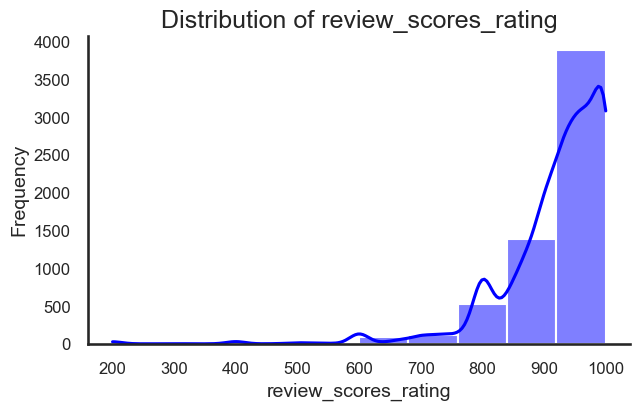

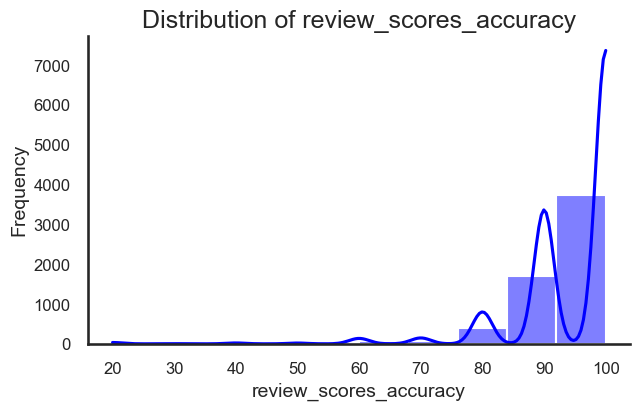

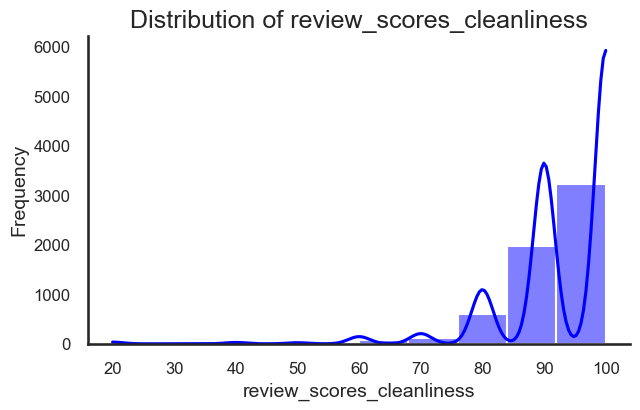

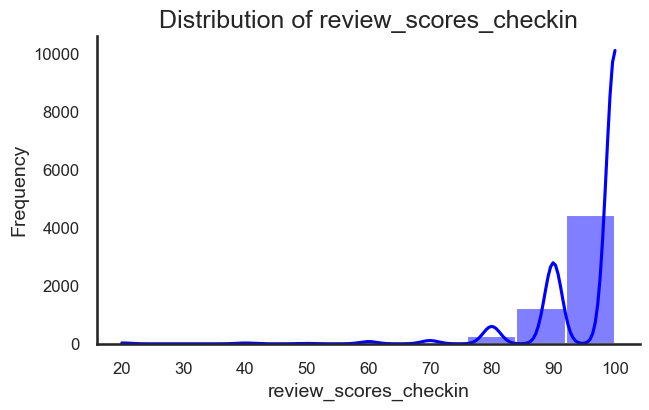

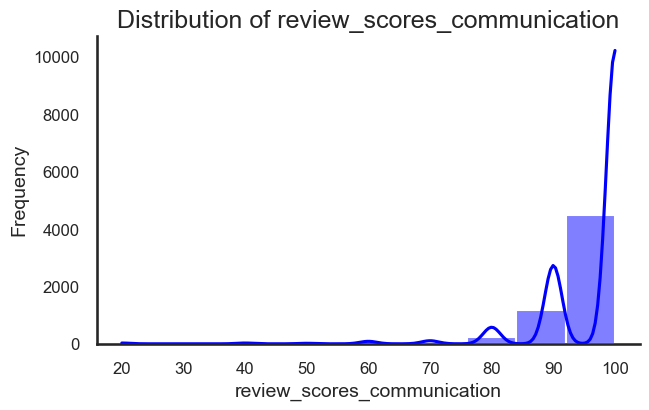

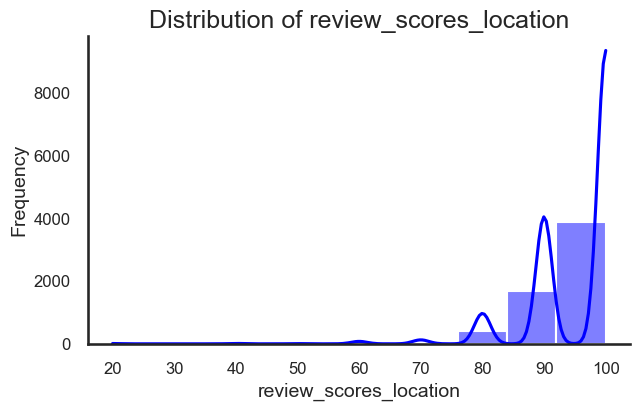

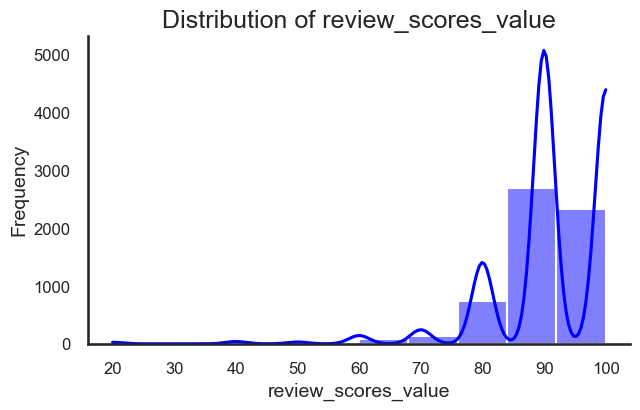

In [914]:
### 1. Distribución de `review_columns` ###
for column in review_columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df_filtered[column], bins=10, kde=True, color='blue')
    plt.xlabel(column)  # Label for the x-axis
    plt.ylabel("Frequency")  # Label for the y-axis
    plt.title(f"Distribution of {column}")  # Title for the plot
    plt.show()

### Normality

In [916]:
# Prueba de normalidad: Kolmogorov-Smirnov
ks_test = ks_2samp(df_filtered['review_scores_rating'], np.random.normal(df_filtered['review_scores_rating'].mean(), df_filtered['review_scores_rating'].std(), size=len(df_filtered)))

# Asimetría y curtosis
skewness = skew(df_filtered['review_scores_rating'])
kurt = kurtosis(df_filtered['review_scores_rating'])

print(f"Kolmogorov-Smirnov p-value: {ks_test.pvalue}")
print(f"Asimetría: {skewness}, Curtosis: {kurt}")

Kolmogorov-Smirnov p-value: 9.193363620555104e-88
Asimetría: -2.77501378446839, Curtosis: 13.705363978338255


**la distribución no es normal**  y debemos usar pruebas no paramétricas para futuros análisis  
**Asimetría = -2.78**  
La distribución es altamente sesgada a la izquierda (hay más valores altos que bajos).  
**Curtosis = 13.71**  
La distribución es leptocúrtica (tiene colas largas y está más concentrada alrededor de ciertos valores).

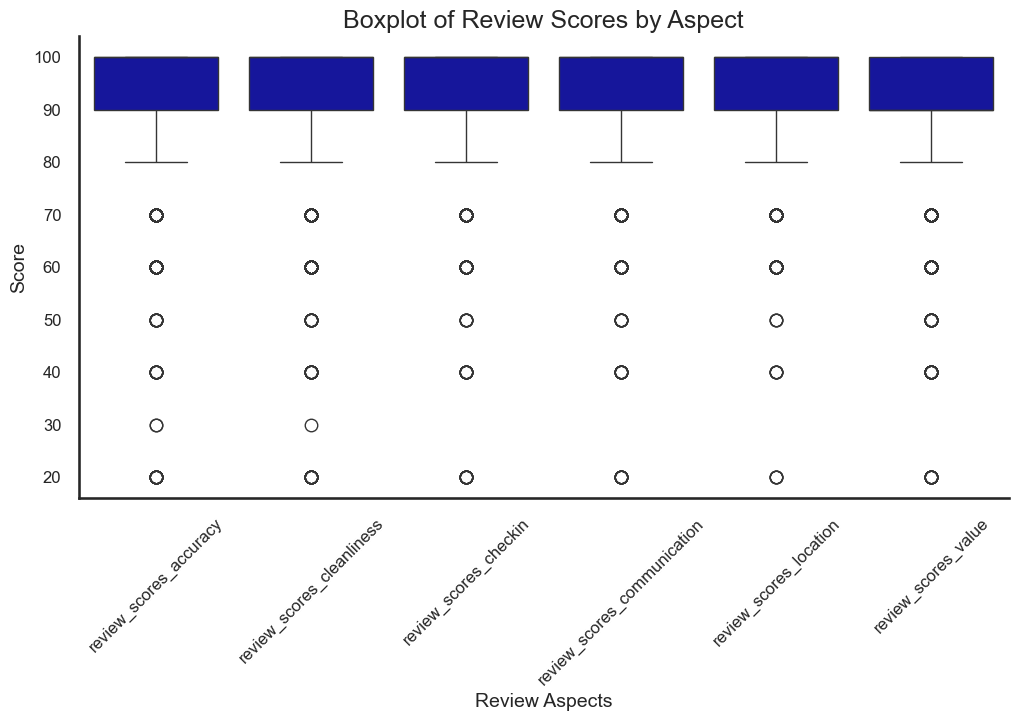

In [918]:
# Melt the DataFrame to have a long format for boxplot
df_melted = df_filtered[aspects].melt(var_name='Aspect', value_name='Score')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Aspect', y='Score', data=df_melted)

# Add labels and title
plt.xlabel("Review Aspects")
plt.ylabel("Score")
plt.title("Boxplot of Review Scores by Aspect")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


## Analysis

Analysis Steps:
1. Segment the data into two groups: the best and worst accommodations based on review_scores_rating.
 - Created quintiles (Q1-Q5) based on overall rating distribution
 - Selected extreme groups: Q5 (top 20%) vs Q1 (bottom 20%)

2. Statistical Comparison For each aspect (accuracy, cleanliness, etc.):
 - Used Mann-Whitney U test (non-parametric)
 - Calculated Cliff's Delta effect size
 - Calculate the average values of different review aspects for both groups.
    - Compute the difference between the mean values of each metric.
    - Identify the aspects with the largest discrepancies between the two groups.

### 1. Clasificación en Rangos (Quintiles)

Quintile boundaries (based on review_scores_rating):
Quintile 1: 200.00
Quintile 2: 870.00
Quintile 3: 922.00
Quintile 4: 960.00
Quintile 5: 990.00
Quintile 6: 1000.00

Distribution across quintiles:
rating_quintil
Q3    1544
Q1    1260
Q2    1156
Q5    1072
Q4    1007
Name: count, dtype: int64


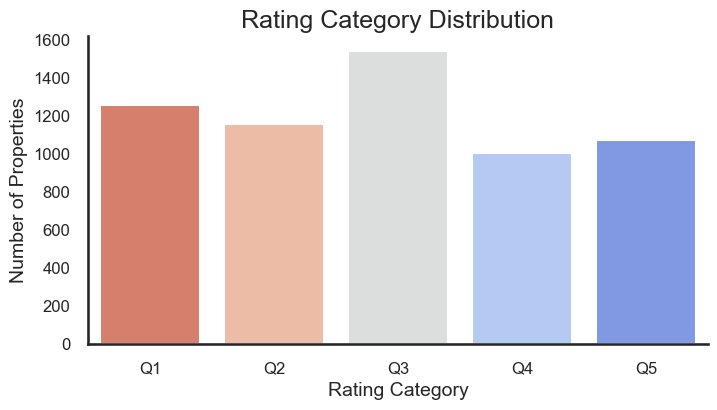

In [922]:
# Calculate quintile groups for the 'review_scores_rating' column
quintile_bins = df_filtered['review_scores_rating'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).to_dict()
df_filtered['rating_quintil'] = pd.qcut(df_filtered['review_scores_rating'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df_filtered.to_csv('df_filtered.csv')

# Print the quintile boundaries
print("Quintile boundaries (based on review_scores_rating):")
for i, (quantile, value) in enumerate(quintile_bins.items()):
    print(f"Quintile {i+1}: {value:.2f}")

# Show the number of elements in each quintile
print("\nDistribution across quintiles:")
print(df_filtered['rating_quintil'].value_counts())

# Visualization of the classification
plt.figure(figsize=(8, 4))
sns.countplot(x=df_filtered['rating_quintil'], palette="coolwarm_r")
plt.xlabel("Rating Category")
plt.ylabel("Number of Properties")
plt.title("Rating Category Distribution")
plt.show()



Clasificación por Quintiles
Los 5 grupos tienen una distribución desigual:
Q3 (1544 propiedades) es el grupo más grande
Q5 (1072 propiedades) es el más pequeño
Parece haber una concentración de valores en los rangos intermedios

In [924]:
quantile_edges = list(quintile_bins.values())
intervals = [f"{quantile_edges[i]:.2f} – {quantile_edges[i+1]:.2f}" for i in range(5)]
quintile_counts = df_filtered['rating_quintil'].value_counts().sort_index()
quintile_summary = pd.DataFrame({
    'Quintile': ['Q5 (Best-rated)', 'Q4', 'Q3', 'Q2', 'Q1 (Worst-rated)'],
    'Rating Interval': intervals[::-1],  
    'Number of Records': quintile_counts[::-1].values  
})
print(quintile_summary.to_string(index=False))

        Quintile  Rating Interval  Number of Records
 Q5 (Best-rated) 990.00 – 1000.00               1072
              Q4  960.00 – 990.00               1007
              Q3  922.00 – 960.00               1544
              Q2  870.00 – 922.00               1156
Q1 (Worst-rated)  200.00 – 870.00               1260


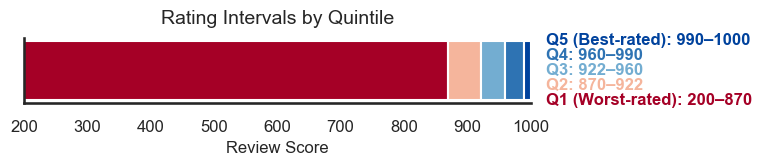

In [925]:
boundaries = list(quintile_bins.values())
labels = ['Q1 (Worst-rated)', 'Q2', 'Q3', 'Q4', 'Q5 (Best-rated)']
colors = ['#a50026', '#f5b59c', '#73add1', '#2e73b3', '#00429d']  # worst → best
widths = [boundaries[i+1] - boundaries[i] for i in range(len(boundaries) - 1)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 2))

# Plot stacked bar
left = boundaries[0]
for i in range(len(widths)):
    ax.barh(0, width=widths[i], left=left, height=0.6,
            color=colors[i], edgecolor='white')
    left += widths[i]

# Add legend-like text on the right
for i, label in enumerate(labels[::-1]):
    interval_text = f"{boundaries[4 - i]:.0f}–{boundaries[5 - i]:.0f}"
    ax.text(boundaries[-1] + 25, 0.3 - i * 0.15,
            f"{label}: {interval_text}",
            color=colors[::-1][i], fontsize=12,
            va='center', ha='left', fontweight='bold')

# Show X-axis with ticks
ax.set_xlim(200, 1000)
ax.set_xticks(range(200, 1051, 100))
ax.set_xlabel("Review Score", fontsize=12)
ax.set_yticks([])  # Hide y-axis

# Title and formatting
ax.set_title("Rating Intervals by Quintile", fontsize=14, pad=10)
plt.tight_layout()
plt.show()


In [926]:
best_rated = df_filtered[df_filtered['rating_quintil'] == 'Q5']
worst_rated = df_filtered[df_filtered['rating_quintil'] == 'Q1']

print(f"Best_rated size: {len(best_rated)}")
print(f"Worst_rated size: {len(worst_rated)}")

Best_rated size: 1072
Worst_rated size: 1260


In [927]:
best_rated['review_scores_rating'].value_counts()

review_scores_rating
1000.00    1072
Name: count, dtype: int64

In [928]:
worst_rated['review_scores_rating'].value_counts().sort_values()

review_scores_rating
300.00      1
660.00      1
630.00      1
470.00      1
550.00      2
680.00      3
530.00      3
690.00      3
640.00      4
650.00      4
740.00      5
500.00      6
710.00      6
760.00     10
720.00     11
790.00     11
200.00     13
400.00     14
670.00     18
770.00     18
750.00     25
780.00     26
730.00     27
810.00     28
700.00     33
820.00     38
830.00     61
600.00     63
840.00     78
860.00    100
850.00    120
870.00    189
800.00    337
Name: count, dtype: int64

### 2. Statistical test 

In [930]:
def compare_aspects_by_rating(best_rated, worst_rated):
    """
    Compare review aspects between top-rated (Q5) and bottom-rated (Q1) accommodations
    with comprehensive missing data handling and statistical testing.
    """
    
    results = []
    
    for aspect in aspects:
        # Extract scores
        top_scores = best_rated[aspect]
        bottom_scores = worst_rated[aspect]
        
        # Skip if insufficient data
        if len(top_scores) < 3 or len(bottom_scores) < 3:
            print(f"Skipping {aspect.replace('review_scores_', '')}: insufficient data "
                  f"(Top n={len(top_scores)}, Bottom n={len(bottom_scores)})")
            continue
            
        # Default to non-parametric test
        test_used = 'Mann-Whitney U'
        stat, p = mannwhitneyu(top_scores, bottom_scores, alternative='two-sided')
        effect_size = (2*stat/(len(top_scores)*len(bottom_scores))) - 1  # Cliff's delta
        
        # Only attempt normality check if sufficient data (Shapiro works best with 3-50 samples)
        if len(top_scores) >= 20 and len(bottom_scores) >= 20:
            _, top_p = stats.shapiro(top_scores)
            _, bottom_p = stats.shapiro(bottom_scores)
            
            if top_p > 0.05 and bottom_p > 0.05:
                # Use parametric test if both groups normal
                stat, p = ttest_ind(top_scores, bottom_scores, equal_var=False)
                test_used = "Welch's t-test"
                effect_size = (top_scores.mean() - bottom_scores.mean()) / np.sqrt(
                    (top_scores.std()**2 + bottom_scores.std()**2)/2)  # Cohen's d
        
        results.append({
            'Aspect': aspect.replace('review_scores_', ''),
            'Top_Mean': top_scores.mean(),
            'Bottom_Mean': bottom_scores.mean(),
            'Mean_Difference': top_scores.mean() - bottom_scores.mean(),
            'Cliffs_Delta': (2*stat/(len(top_scores)*len(bottom_scores))) - 1,  # Всегда вычисляем
            'Cohens_d': (top_scores.mean() - bottom_scores.mean()) / np.sqrt(
               (top_scores.std()**2 + bottom_scores.std()**2)/2),  # Всегда вычисляем
            'Effect_Size': 'Cliffs_Delta' if test_used == 'Mann-Whitney U' else 'Cohens_d',
            #'Effect_Size': effect_size,
            'p_value': p,
            'Test_Used': test_used,
            'Top_n': len(top_scores),
            'Bottom_n': len(bottom_scores)
        })


    if not results:
        raise ValueError("No aspects could be analyzed - insufficient data in all cases")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Multiple testing correction
    pvals = results_df['p_value']
    _, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
    results_df['p_value_adj'] = pvals_corrected
    results_df['Significant'] = pvals_corrected < 0.05
    
    return results_df.sort_values('Effect_Size', ascending=False)

# Execute the analysis
try:
    analysis_results = compare_aspects_by_rating(best_rated, worst_rated)
    
    # Display formatted results
    pd.set_option('display.float_format', '{:.3f}'.format)
    print("="*80)
    print("STATISTICAL COMPARISON OF REVIEW ASPECTS")
    print(f"Top Rated (Q5) vs Bottom Rated (Q1) Accommodations")
    print("="*80)
    print(analysis_results[['Aspect', 'Top_Mean', 'Bottom_Mean', 'Mean_Difference', 'Cliffs_Delta','Cohens_d',
                          'Effect_Size', 'p_value_adj', 'Significant', 'Test_Used',
                          'Top_n', 'Bottom_n']])
    
except ValueError as e:
    print(f"Analysis Error: {e}")

STATISTICAL COMPARISON OF REVIEW ASPECTS
Top Rated (Q5) vs Bottom Rated (Q1) Accommodations
          Aspect  Top_Mean  Bottom_Mean  Mean_Difference  Cliffs_Delta  \
0       accuracy    98.554       84.635           13.919         0.756   
1    cleanliness    97.752       83.079           14.673         0.732   
2        checkin    98.582       89.286            9.296         0.575   
3  communication    98.909       89.024            9.885         0.598   
4       location    97.099       90.849            6.250         0.396   
5          value    96.838       80.746           16.092         0.783   

   Cohens_d   Effect_Size  p_value_adj  Significant       Test_Used  Top_n  \
0     1.356  Cliffs_Delta        0.000         True  Mann-Whitney U   1072   
1     1.352  Cliffs_Delta        0.000         True  Mann-Whitney U   1072   
2     0.953  Cliffs_Delta        0.000         True  Mann-Whitney U   1072   
3     1.026  Cliffs_Delta        0.000         True  Mann-Whitney U   1072   

### 3. Visualization

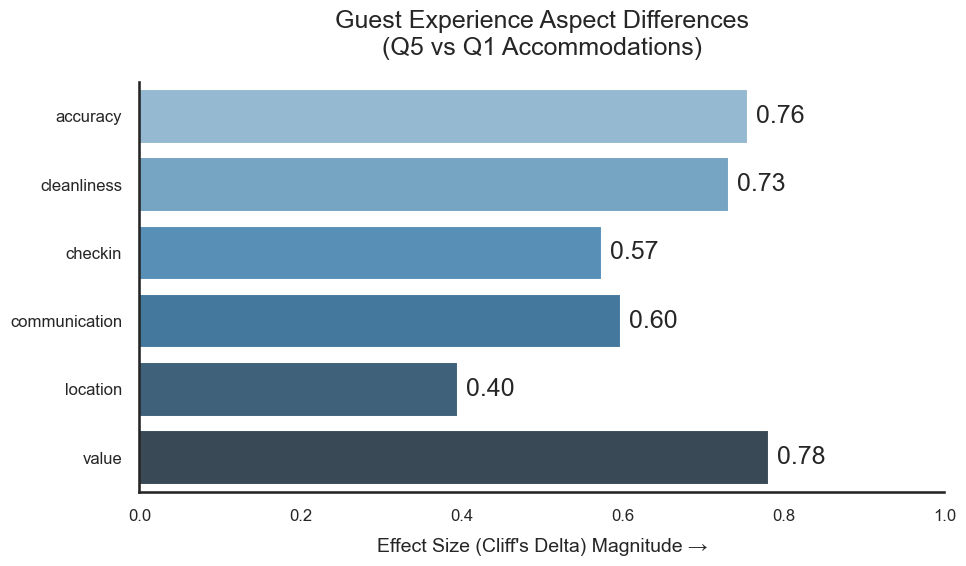

In [987]:
plt.figure(figsize=(10,6))
blue_palette = sns.color_palette("Blues_d", n_colors=6)
ax = sns.barplot(
    data=analysis_results, 
    x='Cliffs_Delta', 
    y='Aspect',
    palette=blue_palette
)
# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}", 
                (p.get_width() + 0.04, p.get_y() + 0.4),
                ha='center', va='center')
plt.title("Guest Experience Aspect Differences\n(Q5 vs Q1 Accommodations)", pad=20)
plt.xlabel("Effect Size (Cliff\'s Delta) Magnitude →", labelpad=10)
plt.ylabel("")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('effect_sizes.png', dpi=300, bbox_inches='tight')

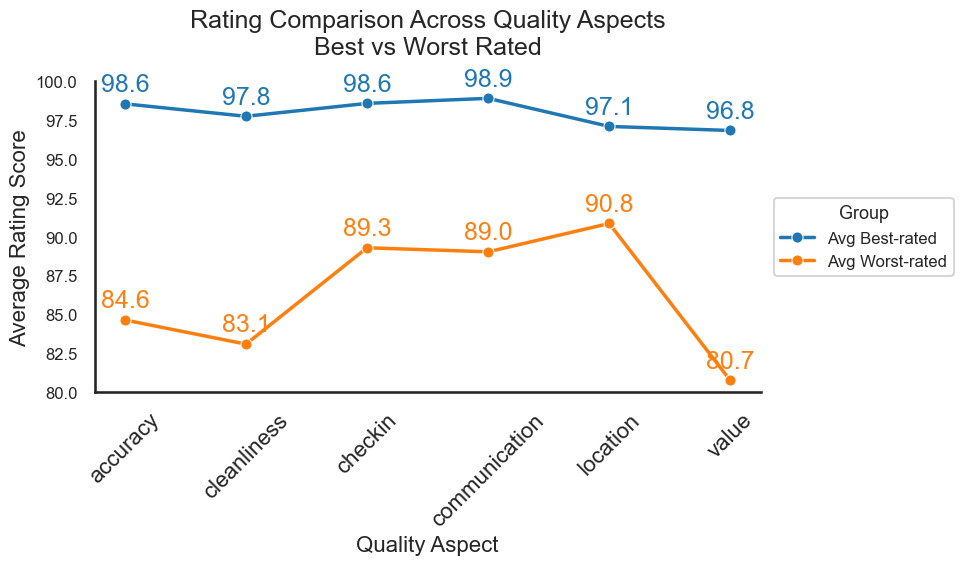

In [935]:
plt.figure(figsize=(10, 6))

# Prepare data - melt the dataframe for plotting
plot_data = analysis_results.melt(id_vars=['Aspect'], 
                                 value_vars=['Top_Mean', 'Bottom_Mean'],
                                 var_name='Group', 
                                 value_name='Score')
plot_data['Group'] = plot_data['Group'].map({
    'Top_Mean': 'Avg Best-rated',
    'Bottom_Mean': 'Avg Worst-rated'
})
# Create parallel coordinates plot
sns.lineplot(data=plot_data,
             x='Aspect',
             y='Score',
             hue='Group',
             palette=['#1f77b4', '#ff7f0e'],  # Blue for top, orange for bottom
             marker='o',
             linewidth=2.5,
             markersize=8,
             sort=False)  # Maintain original aspect order

# Customize plot
plt.title('Rating Comparison Across Quality Aspects\nBest vs Worst Rated', pad=20)
plt.xlabel('Quality Aspect', fontsize=16)
plt.ylabel('Average Rating Score',fontsize=16)
plt.ylim(80, 100)  # Set consistent y-axis range
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Group',     loc='center left',
    bbox_to_anchor=(1.02, 0.5),    borderaxespad=0,
    fontsize=12,
    title_fontsize=13)



# Add value annotations
for group in ['Top_Mean', 'Bottom_Mean']:
    for i, row in analysis_results.iterrows():
        plt.text(i, row[group]+0.5, f"{row[group]:.1f}", 
                 ha='center', va='bottom',
                 color='#1f77b4' if group == 'Top_Mean' else '#ff7f0e')
plt.grid(False)

plt.tight_layout()
plt.show()

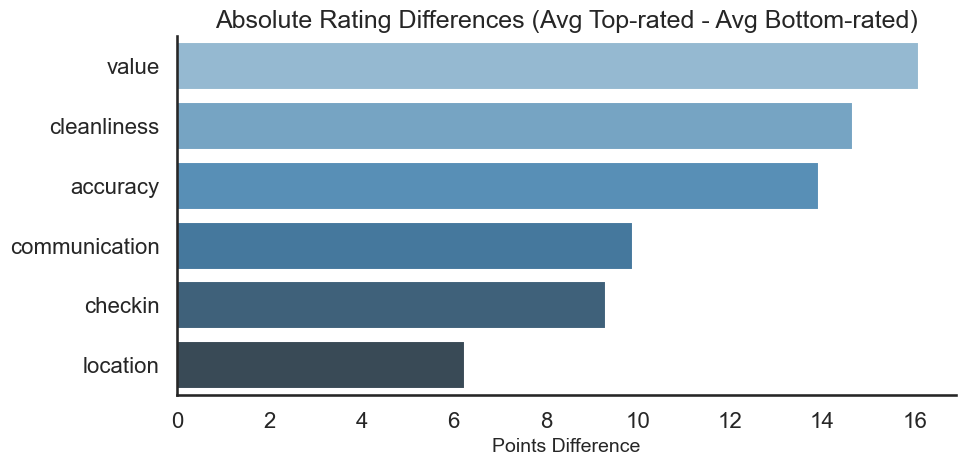

In [936]:
analysis_results_sorted = analysis_results.sort_values(by='Mean_Difference', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(
    data=analysis_results_sorted,
    x='Mean_Difference', y='Aspect',
    palette=blue_palette,
    dodge=False
)
plt.title("Absolute Rating Differences (Avg Top-rated - Avg Bottom-rated)")
plt.xlabel("Points Difference")
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend().remove()
plt.tight_layout()
plt.show()


#### Violinplot

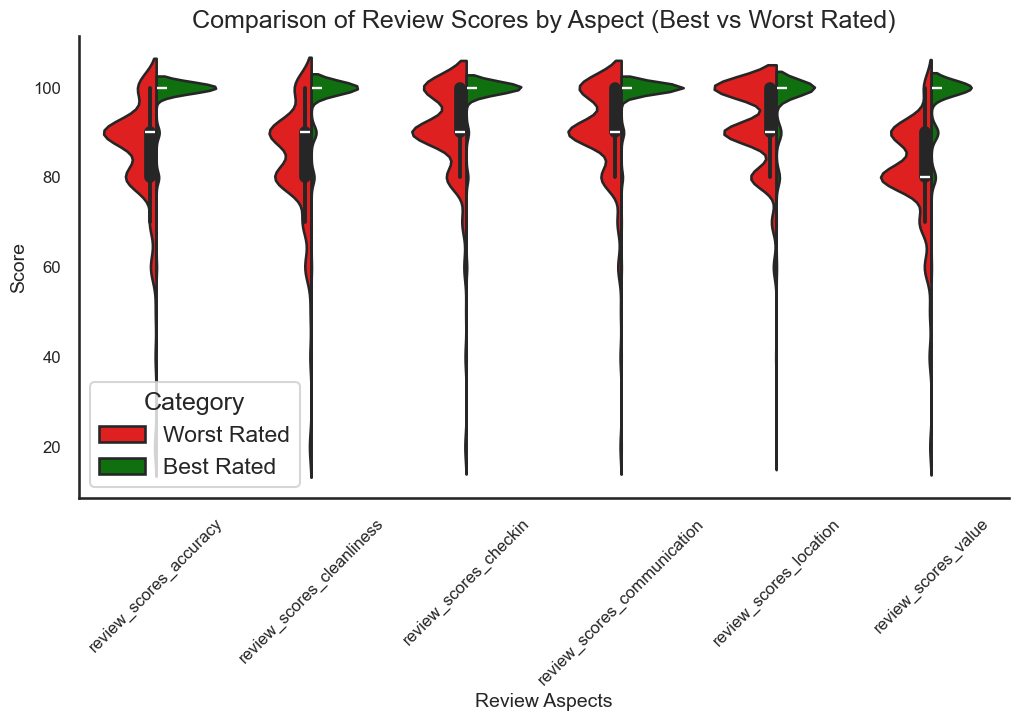

In [938]:
# Add a category column to both datasets
worst_rated["Category"] = "Worst Rated"
best_rated["Category"] = "Best Rated"

# Concatenate both datasets
df_combined = pd.concat([worst_rated, best_rated])

# Melt the DataFrame to long format
df_melted = df_combined.melt(id_vars=["Category"], value_vars=aspects, var_name="Aspect", value_name="Score")

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="Aspect", y="Score", hue="Category", data=df_melted, split=True, palette=["red", "green"])

# Customize the plot
plt.xlabel("Review Aspects")
plt.ylabel("Score")
plt.title("Comparison of Review Scores by Aspect (Best vs Worst Rated)")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()


#### Heatmap

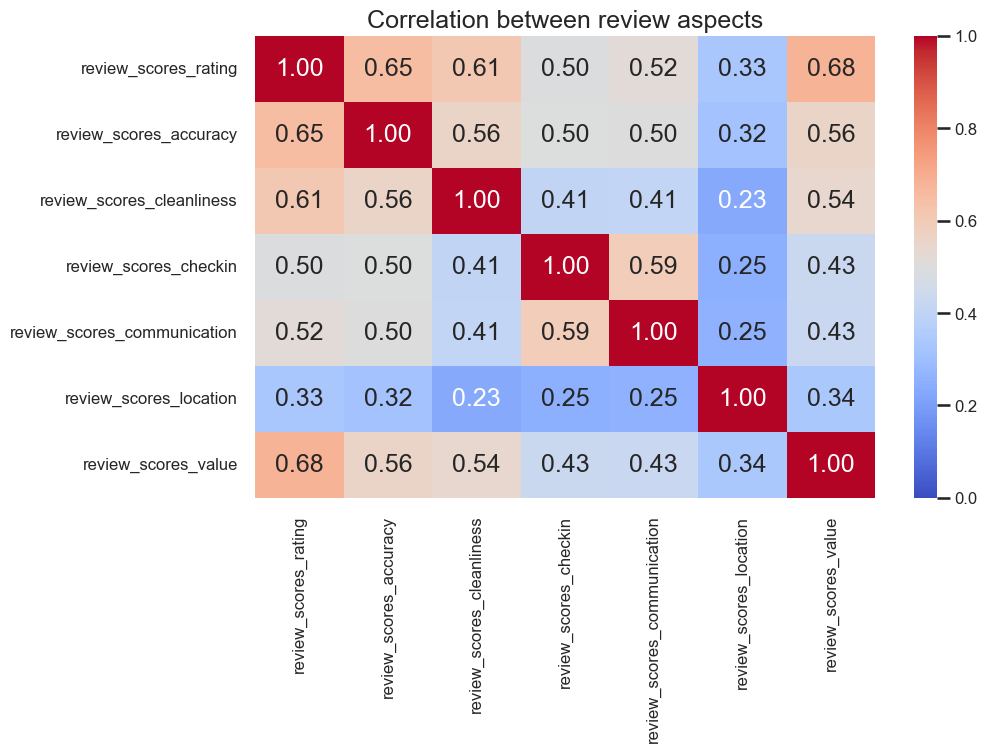

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.732
Model:                              OLS   Adj. R-squared:                  0.732
Method:                   Least Squares   F-statistic:                     2749.
Date:                  Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                          22:29:18   Log-Likelihood:                -31651.
No. Observations:                  6039   AIC:                         6.332e+04
Df Residuals:                      6032   BIC:                         6.336e+04
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [940]:

# Selecting only numerical columns related to review scores
review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Correlation matrix
plt.figure(figsize=(10, 6))
#sns.heatmap(df_filtered[review_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
sns.heatmap(df_filtered[review_columns].corr(method='spearman'), annot=True, cmap="coolwarm", fmt=".2f", vmin=0)
plt.title("Correlation between review aspects")
plt.show()

# Linear regression: predicting overall rating
X = df_filtered[['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value']]
X = sm.add_constant(X)  # Adding a constant term for the model
y = df_filtered['review_scores_rating'].dropna()  # Target variable

model = sm.OLS(y, X.loc[y.index]).fit()
print(model.summary())




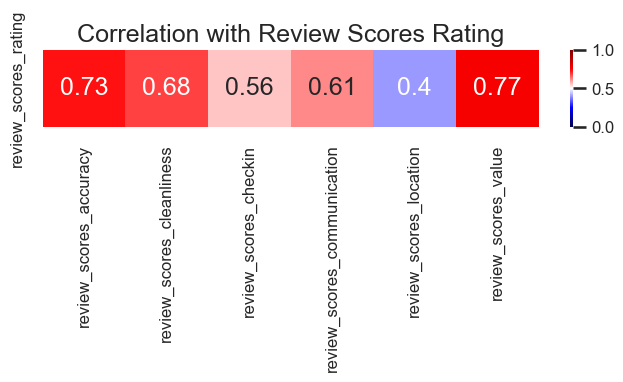

In [941]:
plt.figure(figsize=(8, 1))  
sns.heatmap(df_filtered[review_columns].corr().iloc[:1, 1:], annot=True, cmap="seismic", vmin=0, vmax=1)
plt.title("Correlation with Review Scores Rating")
plt.show()

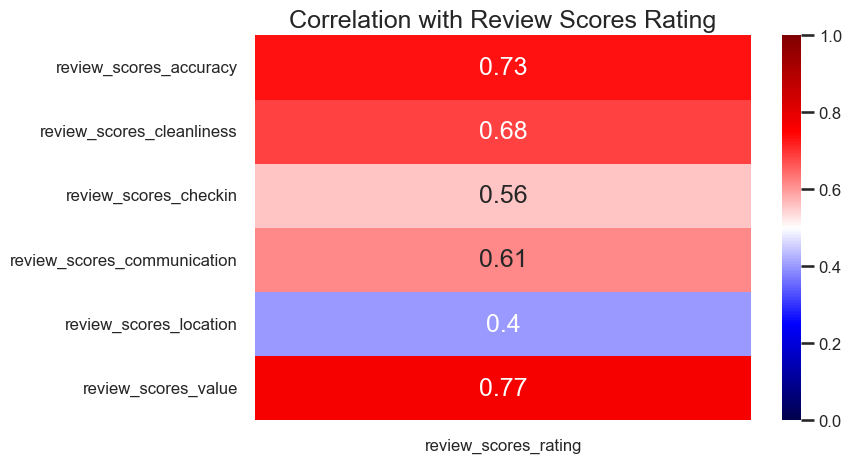

In [1001]:
plt.figure(figsize=(8, 5))
sns.heatmap(df_filtered[review_columns].corr().iloc[:1, 1:].T, annot=True, cmap="seismic", vmin=0, vmax=1)
plt.title("Correlation with Review Scores Rating")
plt.show()


In [997]:
# Calculate the correlation
correlation_table = df_filtered[review_columns].corr()

# Display the correlation table for the review aspects with respect to the overall rating
print(correlation_table.iloc[:1, 1:])


                      review_scores_accuracy  review_scores_cleanliness  \
review_scores_rating                   0.732                      0.685   

                      review_scores_checkin  review_scores_communication  \
review_scores_rating                  0.558                        0.613   

                      review_scores_location  review_scores_value  
review_scores_rating                   0.402                0.767  
